In [29]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade
!pip install evaluate
!pip install wandb

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer,AutoModel,AutoModelForSequenceClassification,AutoConfig,TrainingArguments,Trainer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import torch
from sklearn.metrics import accuracy_score, f1_score,classification_report,confusion_matrix
import os
os.environ["WANDB_DISABLED"] = "true"

In [3]:
df=pd.read_csv('/content/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


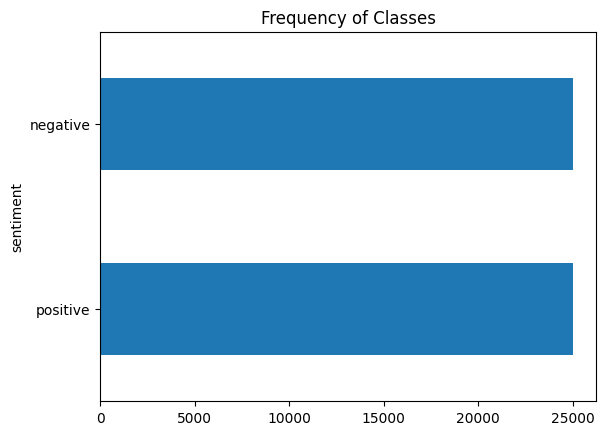

In [5]:
label_counts = df['sentiment'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'Words per Review'}, xlabel='sentiment'>

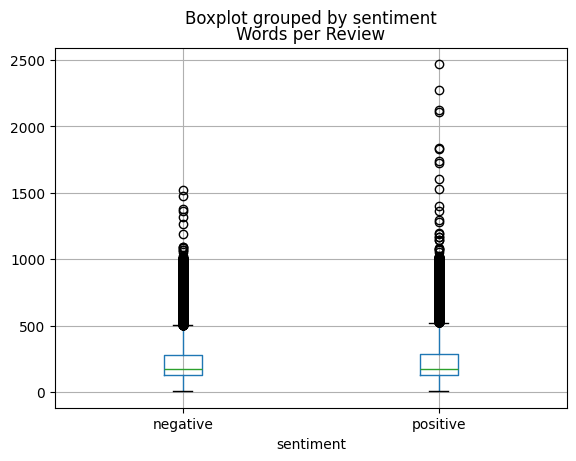

In [6]:
df['Words per Review'] = df['review'].str.split().apply(len)
df.boxplot("Words per Review", by="sentiment")

In [7]:
model_ckpt = "bert-base-uncased"  #ENGLISH english
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
text = "We love to sleep! Winters are awesome!"
encoded_text = tokenizer(text)
print(encoded_text)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 2057, 2293, 2000, 3637, 999, 12214, 2024, 12476, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [8]:
len(tokenizer.vocab),tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

In [9]:
train, test = train_test_split(df, test_size=0.3, stratify=df['sentiment'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['sentiment'])
train.shape, test.shape, validation.shape

((35000, 3), (10000, 3), (5000, 3))

In [10]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(train, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False),
    "validation": Dataset.from_pandas(validation, preserve_index=False)
})

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'Words per Review'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'Words per Review'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'Words per Review'],
        num_rows: 5000
    })
})

In [12]:
dataset['train'][0]

{'review': 'Rented 3 bad movies to watch with my friends in my dorm room.<br /><br />Leprechaun 4, Jack Frost and The Prey.<br /><br />I picked up Jack and Lep 4 because they are well known bad movies I have never seen.<br /><br />I picked this movie out because it matched the "How to find a bad movie" guide on badmovies.org, No real description, no pics of the movie on the back, and I had never heard of it, had to be a winner :)<br /><br />(SPOILERS, but this movie is so awful it doesn\'t matter :P)<br /><br />This is a TRUE bad movie, Lep 4 and Jack Frost are dumb on purpose, this is dumb despite the best efforts of the cast and crew.<br /><br />This "movie" starts out much like Evil Dead, even the actors look similar and have the same style of dress. Unlike Evil Dead it never gains any speed at all. For a "slasher" movie it is pretty bland, in 80 minutes 6 people get killed, but these are spread apart so far it becomes quickly boring.<br /><br />The director threw in a lot of boring

In [13]:
def tokenize(batch):
    temp= tokenizer(batch['review'], padding=True, truncation=True, return_token_type_ids=True,)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 12524, 1017, 2919, 5691, 2000, 3422, 2007, 2026, 2814, 1999, 2026, 19568, 2282, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 3393, 28139, 7507, 4609, 1018, 1010, 2990, 10097, 1998, 1996, 8336, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1045, 3856, 2039, 2990, 1998, 3393, 2361, 1018, 2138, 2027, 2024, 2092, 2124, 2919, 5691, 1045, 2031, 2196, 2464, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1045, 3856, 2023, 3185, 2041, 2138, 2009, 10349, 1996, 1000, 2129, 2000, 2424, 1037, 2919, 3185, 1000, 5009, 2006, 2919, 5302, 25929, 1012, 8917, 1010, 2053, 2613, 6412, 1010, 2053, 27263, 2015, 1997, 1996, 3185, 2006, 1996, 2067, 1010, 1998, 1045, 2018, 2196, 2657, 1997, 2009, 1010, 2018, 2000, 2022, 1037, 3453, 1024, 1007, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1006, 27594, 2545, 1010, 2021, 2023, 3185, 2003, 2061, 9643, 2009, 2987, 1005, 1056, 3043, 1024, 1052, 1007, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 2023, 2003, 1037, 2995,

In [14]:
emotion_encoded=dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [15]:
sentiment_id = list({x['sentiment'] for x in dataset ['train']})
id2label = {id:label for id, label in enumerate(sentiment_id)}
label2id = {label:id for id, label in id2label.items()}
sentiment_id, id2label, label2id

(['positive', 'negative'],
 {0: 'positive', 1: 'negative'},
 {'positive': 0, 'negative': 1})

In [16]:
model= AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [17]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [18]:
model.config
model_two="bert-base-cased"

In [19]:
Num_labels = len(label2id)
device = torch.device ("cuda" if torch. cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
device

device(type='cuda')

In [21]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [22]:
batch_size=64
training_dir = "bert_base_training_dir"
training_args= TrainingArguments(output_dir = training_dir,
              overwrite_output_dir = True,
              num_train_epochs = 2,
              learning_rate = 2e-5,
              per_device_train_batch_size = batch_size,
              per_device_eval_batch_size = batch_size,
              weight_decay = 0.01,
              evaluation_strategy = 'epoch',
              disable_tqdm = False
    )

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
def compute_metrics (pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [32]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

In [ ]:
trainer.train()

In [ ]:
preds_output = trainer.predict(emotion_encoded[ 'test'])
preds_output.metrics
preds_output.predictions

In [ ]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [ ]:
print(classification_report(y_true, y_pred))
label2id

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt ='d', cbar=False, cmap='Reds')
plt.yabel("Actual")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.show()

In [ ]:
text = "I am super happy today. I got it done. Finally!!"
def get_prediction (text) :
    input_encoded = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
      outputs = model(**input_encoded)
    logits = outputs. logits
    pred = torch.argmax(logits, dim=1) .item()
    return id2label[pred]
get_prediction (text)

In [ ]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [ ]:
# use pipeline for prediciton
from transformers import pipeline
classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')
classifier([text, 'A very good day indeed', "We loved mth111", "I am feeling anxious"])